In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from scipy.optimize import differential_evolution

# Introducción

La estimación de la temperatura en el océano es una necesidad para el desarrollo de proyectos de generación sustentable de energía eléctrica. Por ejemplo, la tecnología Ocean Thermal Energy Conversion (OTEC), aprovecha el gradiente de temperatura entre la superficie marina y el fondo, sin embargo, su funcionamiento exige una diferencia de 20 grados centígrados, por lo menos, entre dos puntos cercanos en el océano. Puedes profundizar más sobre este tema en el siguiente enlace:    

https://www.tudelft.nl/oceanenergy/research/thermal-gradient-otec



# Objetivo

El objetivo de este proyecto es el construir un modelo no lineal de la temperatura del Mar Caribe mexicano a partir de un conjunto de datos, que sirva como referencia para ubicar sitios con potencial para explotar el gradiente térmico en la generación de energía eléctrica.


# Datos

El conjunto con el que desarrollarás este proyecto se compone de valores de temperatura muestraedos en diferentes sitios del Mar Caribe. Buscamos diseñar un modelo con el que podamos estimar la temperatura del mar (variable $\texttt{Temperature}$) a partir de los siguientes predictores:

* $\texttt{Depth}$:  profundidad
* $\texttt{Latitude}$: latitud geográfica
* $\texttt{Longitude}$: longitud geográfica
* $\texttt{Ts}$: temperatura superficial
* $\texttt{Month}$: mes del año.

La siguiente celda muestra las primeras filas de este conjunto.


In [ ]:
data = pd.read_csv("datos_tmp.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head()

,Depth,Temperature,Cast,Cruise,Latitude,Longitude,Day,Month,Year,Ts
0,0.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
1,5.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
2,10.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
3,15.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
4,20.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821


El principal predictor de la temperatura es la profundidad en la que se debe estimar. En la siguiente celda puedes ver la gráfica de dispersión mostrando el patrón que sigue la temperatura en función de la profundidad.    

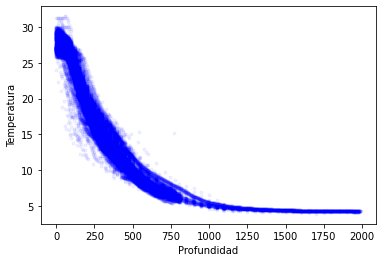

In [ ]:
plt.plot(data["Depth"], data["Temperature"], "b.", alpha=0.05)
plt.xlabel("Profundidad")
plt.ylabel("Temperatura")
plt.show()

Observamos que la temperatura alcanza valores entre 25 y 30 grados cerca de la superficie y desciende hasta los 4 grados a partir de los 1000 metros.

## Dos patrones

La dispersión podría explicarse mediante dos patrones. El primero se identifica cerca de la superficie, posiblemente hasta alrededor de 150-180 metros de profundidad, en el que la temperatura tiene un descenso poco pronunciado (posiblemente lineal). Inmediatemante después, identificamos un segundo patrón caracterizado por una disminución drástica de la temperatura, hasta tender a los 4 grados centígrados en la parte más profunda. Este último patrón parece ajustarse a una exponencial.


## Modelo básico

Podemos pensar en un primer modelo en el que utilicemos solamente la profundidad, $z$, como predictor de la temperatura. El modelo puede tener la siguiente estructura:

$$
  \widehat{T}(z) =
  \begin{cases}
    a_0+a_1z, & z < z_0 \\
    b_0+b_1e^{b_2 z}, & z\geq z_0 \\
  \end{cases}
$$

Siendo $a_0, a_1, b_0, b_1$ y $b_2$ números reales (los parámetros del modelo), mientras que $z_0$ es la profundidad en la que termina el primer patrón del modelo e inicia el segundo.

Los parámetros pueden determinarse minimizando el promedio del valor absoluto del error de predicción:

$$MAE(a_0, a_1, b_0, b_1, b_2, z_0) = \frac{1}{N}\sum_{i=1}^N|T_i-\widehat{T}(z_i)|$$

siendo $T_i$ la temperatura registrada en la i-ésima fila de la tabla de datos y $\widehat{T}(z_i)$ la estimada por el modelo para la profundidad $z_i$ (en la que se registró $T_i$).

**Utiliza algún algoritmo evolutivo para ajustar los parámetros del modelo**




# Distribución espacial

Las posiciones en las que se tomaron las muestras de temperatura se pueden observar en el siguiente mapa:

In [ ]:
casts = data[["Cast", "Latitude", "Longitude"]]
casts_loc =  casts.groupby(["Cast"]).last()
casts_loc.head()

,Latitude,Longitude
Cast,,
2711244,21.075,-86.058
2711245,21.090,-86.000
2711247,21.107,-85.933
2711259,20.842,-86.542
2711260,20.817,-86.575


In [ ]:
!pip install ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ipyleaflet import *

In [ ]:
m_casts = Map(center=(21, -86), zoom=6.25, basemap=basemaps.Esri.DeLorme)

for i in range(len(casts_loc)):
    #mrkr = CircleMarker(location=)
    #mrkrs.append(mrkr)

    circle = Circle()
    circle.location = (casts_loc.iloc[i]["Latitude"], casts_loc.iloc[i]["Longitude"])
    circle.radius = 50
    circle.color = "blue"
    circle.fill_color = "blue"

    m_casts.add_layer(circle);
m_casts


Dado que las muestras abarcan una región espacial muy amplia, es de esperar que la temperatura medida a una profundidad, en el norte de esta región, sea más baja si se compara con una muestra tomada a la misma profundidad pero al sur. Este razonamiento nos lleva a pensar en extender el modelo para considerar la ubicación geográfica (latitud y longitud) del punto en el que se realizará la estimación.

Considera el siguienyte modelo:

# Modelo con predictores geográficos  

$$
T(z)
\begin{cases}
    a_0+(a_1+a_2x+a_3y+a_4xy)z,& \text{ si } z < z_{0}\\
    &\\
    b_0+(b_1+b_2x+b_3y+b_4xy)e^{b_5z},& \text{ si }  z \geq z_{0}
\end{cases}
$$

en donde $a_i$ y $b_i$ son parámetros reales que deben determinarse minimizando el promedio del valor absoluto del error. Las variables predictoras son la profundidad, $z$, la latitud, $y$, y la longitud $x$.

**Utiliza algún algoritmo evolutivo para ajustar los parámetros del modelo a los datos**









# Otros predictores [reto]

Los dos modelos propuestos no consideran predictores que pueden ser importantes en la estimación de la temperatura, como el mes del año o la temperatura observada en la superficie del mar. ¿Se te ocurre alguna idea para integrar esas variables en un nuevo modelo?.  

# Modelo basico

In [ ]:
data = pd.read_csv("datos_tmp.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head()

In [ ]:
puntoX = data['Depth'].values
puntoY = data['Temperature'].values

In [ ]:
def func_lineal(puntoX,a0,a1):
  return a0*puntoX + a1

In [ ]:
def func_no_lineal(puntoX,b0,b1,b2):
  return b0*np.sin(b1*puntoX) + b2

In [ ]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def linear_fit(params):
    a0,a1 = params
    y_pred = func_lineal(puntoX, a0,a1)
    return mae(puntoY, y_pred)


In [ ]:
def nonlinear_fit(params):
    b0,b1,b2 = params
    y_pred = func_no_lineal(puntoX,b0,b1,b2)
    return mae(puntoY, y_pred)

In [ ]:
bounds = [(-150, 150), (-150, 150)]
result_linear = differential_evolution(linear_fit, bounds)
a_linear, b_linear = result_linear.x

In [ ]:
bounds = [(0, 180), (0, 2*np.pi), (-150, 150)]
result_nonlinear = differential_evolution(nonlinear_fit, bounds)
a_nonlinear, b_nonlinear, c_nonlinear = result_nonlinear.x

In [ ]:
y_pred_linear = func_lineal(puntoX, a_linear, b_linear)
y_pred_nonlinear = func_no_lineal(puntoX, a_nonlinear, b_nonlinear, c_nonlinear)
mae_linear = mae(puntoY, y_pred_linear)
mae_nonlinear = mae(puntoY, y_pred_nonlinear)

In [ ]:
print("Modelo de regresión lineal:")
print("Parámetros: a0 = %.2f, a1 = %.2f" % (a_linear, b_linear))
print("MAE: %.2f" % mae_linear)
print("Modelo de regresión no lineal:")
print("Parámetros: b0 = %.2f, b1 = %.2f, b2 = %.2f" % (a_nonlinear, b_nonlinear, c_nonlinear))
print("MAE: %.2f" % mae_nonlinear)

Modelo de regresión lineal:
Parámetros: a0 = -0.03, a1 = 26.15
MAE: 3.40
Modelo de regresión no lineal:
Parámetros: b0 = 6.17, b1 = 0.01, b2 = 15.10
MAE: 5.29


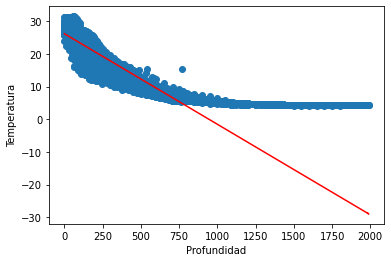

In [ ]:
plt.scatter(puntoX, puntoY )
plt.plot(puntoX, y_pred_linear,"r")
plt.xlabel("Profundidad")
plt.ylabel("Temperatura")
plt.show()

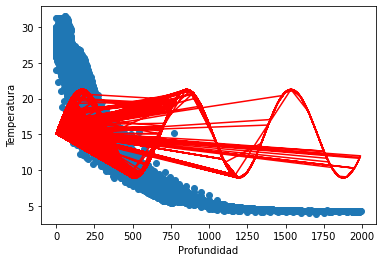

In [ ]:
plt.scatter(puntoX, puntoY )
plt.plot(puntoX, y_pred_nonlinear,"r")
plt.xlabel("Profundidad")
plt.ylabel("Temperatura")
plt.show()

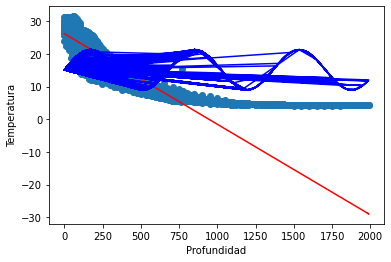

In [ ]:
plt.scatter(puntoX, puntoY )
plt.plot(puntoX, y_pred_linear,"r")
plt.plot(puntoX, y_pred_nonlinear,"b")
plt.xlabel("Profundidad")
plt.ylabel("Temperatura")
plt.show()

# Modelo con predictores geográficos

$$
T(z)
\begin{cases}
    a_0+(a_1+a_2x+a_3y+a_4xy)z,& \text{ si } z < z_{0}\\
    &\\
    b_0+(b_1+b_2x+b_3y+b_4xy)e^{b_5z},& \text{ si }  z \geq z_{0}
\end{cases}
$$

In [ ]:
data = pd.read_csv("datos_tmp.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head()

,Depth,Temperature,Cast,Cruise,Latitude,Longitude,Day,Month,Year,Ts
0,0.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
1,5.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
2,10.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
3,15.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821
4,20.0,29.1,3678873,GB-0,19.85,-86.75,15,9,1981,15.184821


In [ ]:
def fun_lineal(a0,a1,a2,a3,a4):
  return